In [23]:
!pip install opendatasets

In [24]:
import opendatasets as od
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [25]:
# Загрузка датасета
data = od.download(
    "https://www.kaggle.com/datasets/andrewmvd/doom-crossing/data")

Skipping, found downloaded files in "./doom-crossing" (use force=True to force download)


In [29]:
data_ae = keras.utils.image_dataset_from_directory(
    '/content/doom-crossing',
    labels=None,                # без меток
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

data_ae = data_ae.map(lambda x: x / 255.0)
# Для обучения автоэнкодера подготовим пары (X, X)
data_ae = data_ae.map(lambda x: (x, x))

Found 1597 files.


In [30]:
# Энкодер (кодировщик)
encoder = keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
], name='encoder')

# Декодер (дешифратор)
decoder = keras.Sequential([
    layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # выходные пиксели [0,1]
], name='decoder')

# Полный автоэнкодер
input_img = keras.Input(shape=(64, 64, 3))
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = keras.Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Sequential)            │ (None, 8, 8, 128)      │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 64, 64, 3)      │       240,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
hist_ae = autoencoder.fit(
    data_ae,
    epochs=10,
    shuffle=True
)

# Модель `encoder` теперь содержит обученные веса
encoder_model = encoder  # кодировщик для дальнейшего использования

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - loss: 0.6703
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 509ms/step - loss: 0.5520
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 512ms/step - loss: 0.5254
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - loss: 0.5192
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 512ms/step - loss: 0.5092
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 481ms/step - loss: 0.5042
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - loss: 0.5029
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 492ms/step - loss: 0.5016
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 476ms/step - loss: 0.4975
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 494ms/step - loss: 0.4937


In [7]:
def plot_history(hist):
  # График функции потерь
  fig = plt.figure()
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  fig.suptitle('Loss', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

  # График точности
  fig = plt.figure()
  plt.plot(hist.history['accuracy'], label='accuracy')
  plt.plot(hist.history['val_accuracy'], label='val_accuracy')
  fig.suptitle('Accuracy', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

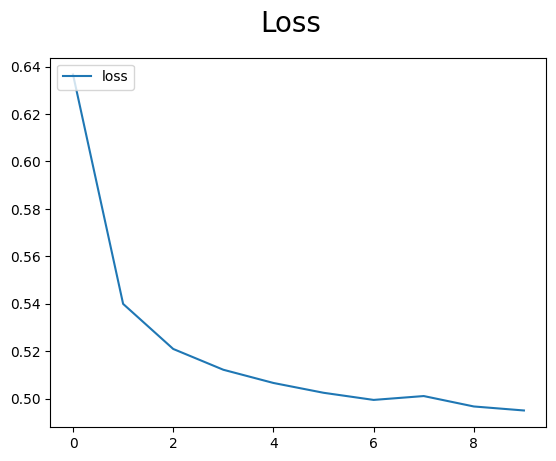

In [32]:
  fig = plt.figure()
  plt.plot(hist_ae.history['loss'], label='loss')
  fig.suptitle('Loss', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()


Примеры реконструкции автокодировщиком:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


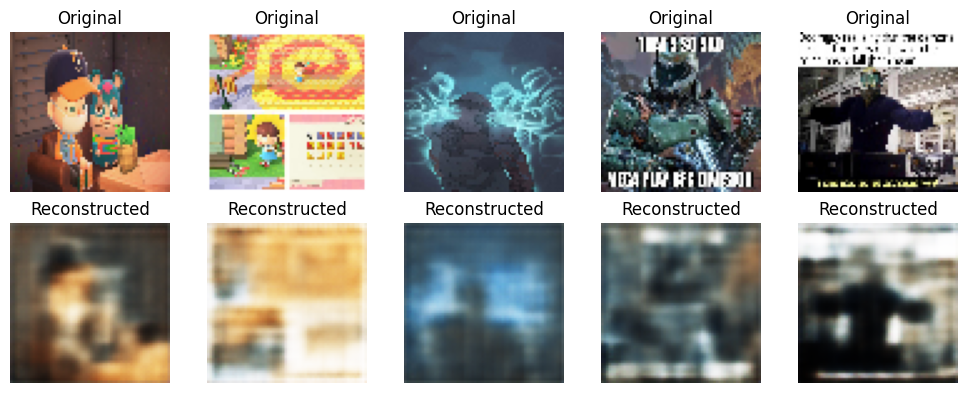

In [33]:
def plot_reconstructions(model, dataset, n_images=5):
    plt.figure(figsize=(10, 4))
    for images, _ in dataset.take(1):
        reconstructed_images = model.predict(images)
        for i in range(n_images):
            # Оригинал
            ax = plt.subplot(2, n_images, i + 1)
            plt.imshow(images[i])
            plt.title("Original")
            plt.axis("off")

            # Реконструкция
            ax = plt.subplot(2, n_images, i + 1 + n_images)
            plt.imshow(reconstructed_images[i])
            plt.title("Reconstructed")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nПримеры реконструкции автокодировщиком:")
plot_reconstructions(autoencoder, data_ae)

In [34]:
data = tf.keras.utils.image_dataset_from_directory('/content/doom-crossing', image_size=(64, 64))

data = data.map(lambda x,y: (x/255, y))

Found 1597 files belonging to 2 classes.


In [35]:
train_size_percentage = 0.7
val_size_percentage = 0.2
test_size_percentage = 0.1

spared_batches = len(data) % 10

train_size = int(len(data) * train_size_percentage)
val_size = int(len(data) * val_size_percentage)
test_size = int(len(data) * test_size_percentage) + spared_batches


train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [39]:
# Классификатор использует обученный encoder + наша сетка
classifier = keras.Sequential([
    encoder_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='classifier')

classifier.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
      ]
    )

In [40]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [41]:
# Обучаем классификатор на размеченных данных (fine-tuning)
hist = classifier.fit(train,
                 epochs=10,
                 validation_data=val,
                 callbacks=[tensorboard_callback])

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6239 - loss: 0.6211 - precision: 0.6306 - recall: 0.6683 - val_accuracy: 0.7375 - val_loss: 0.5214 - val_precision: 0.8182 - val_recall: 0.5844
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7784 - loss: 0.4792 - precision: 0.8083 - recall: 0.7797 - val_accuracy: 0.7344 - val_loss: 0.5054 - val_precision: 0.6774 - val_recall: 0.9074
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8027 - loss: 0.4369 - precision: 0.8129 - recall: 0.8336 - val_accuracy: 0.7719 - val_loss: 0.4782 - val_precision: 0.8071 - val_recall: 0.7107
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8177 - loss: 0.4020 - precision: 0.8534 - recall: 0.8110 - val_accuracy: 0.7656 - val_loss: 0.4720 - val_precision: 0.7544 - val_recall: 0.7963
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8226 - loss: 0.3835 - precision: 0.8372 - recall: 0.8528 - val_accuracy: 0.7531 - val_loss: 0.5032 - val

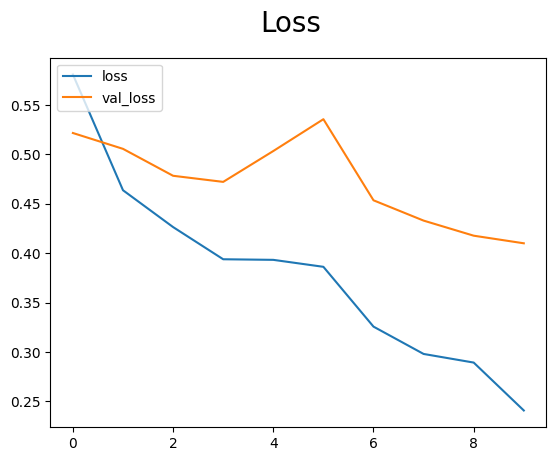

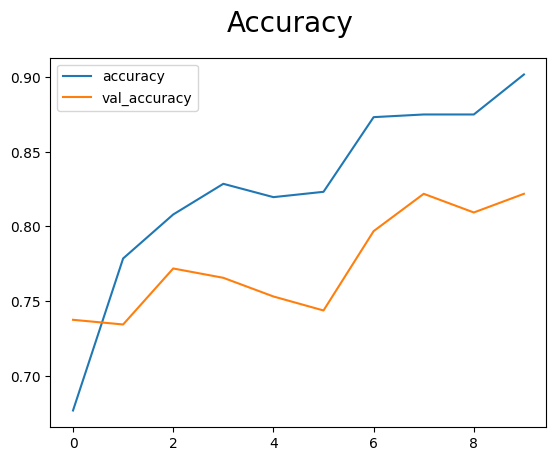

In [42]:
plot_history(hist)

In [43]:
def test_model(model, test):
    y_true = []
    y_pred = []

    precision = Precision()
    recall = Recall()
    binary_accuracy = BinaryAccuracy()

    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)

        y_true.extend(y)
        y_pred.extend((yhat > 0.5).astype(int))

        precision.update_state(y, yhat)
        recall.update_state(y, yhat)
        binary_accuracy.update_state(y, yhat)

    print(f'Precision: {precision.result():.2f}, Recall: {recall.result():.2f}, Binary Accuracy: {binary_accuracy.result():.2f}')

    cm = confusion_matrix(y_true, y_pred)
    labels = test.class_names if hasattr(test, 'class_names') else ['class_0', 'class_1']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Precision: 0.82, Recall: 0.65, Binary Accuracy: 0.75


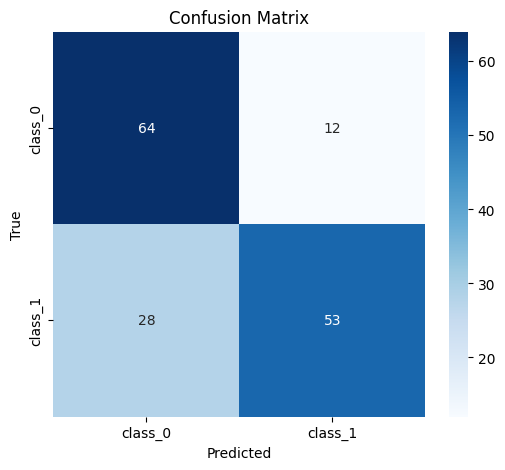

In [44]:
test_model(classifier, test)

In [45]:
classifier_rnn = keras.Sequential([
    encoder_model,
    layers.Reshape((8, 8 * 128)),               # → (8, 1024)
    layers.LSTM(128),        # берет последовательность из 8 шагов
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='classifier_rnn')

classifier_rnn.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
      ]
    )

In [46]:
hist_rnn = classifier_rnn.fit(train,
                 epochs=10,
                 validation_data=val,
                 callbacks=[tensorboard_callback])

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6366 - loss: 0.6336 - precision: 0.6350 - recall: 0.7680 - val_accuracy: 0.7156 - val_loss: 0.5606 - val_precision: 0.6632 - val_recall: 0.8312
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7385 - loss: 0.5297 - precision: 0.7545 - recall: 0.7727 - val_accuracy: 0.7500 - val_loss: 0.5047 - val_precision: 0.7429 - val_recall: 0.7879
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7451 - loss: 0.5037 - precision: 0.7515 - recall: 0.8021 - val_accuracy: 0.7906 - val_loss: 0.4580 - val_precision: 0.8613 - val_recall: 0.7108
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7638 - loss: 0.4726 - precision: 0.7727 - recall: 0.8070 - val_accuracy: 0.7969 - val_loss: 0.4801 - val_precision: 0.7542 - val_recall: 0.8654
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7886 - loss: 0.4473 - precision: 0.7962 - recall: 0.8422 - val_accuracy: 0.7969 - val_loss: 0.4704 - val

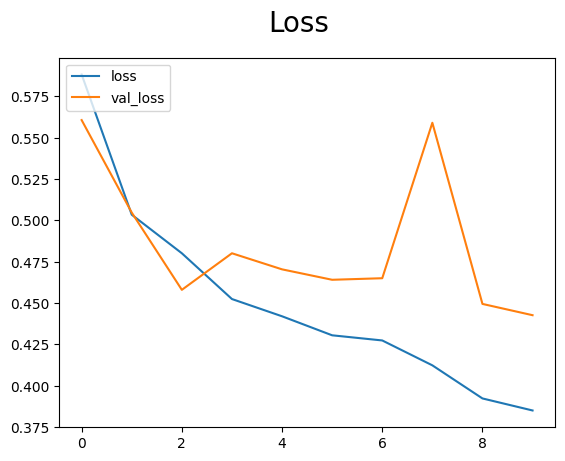

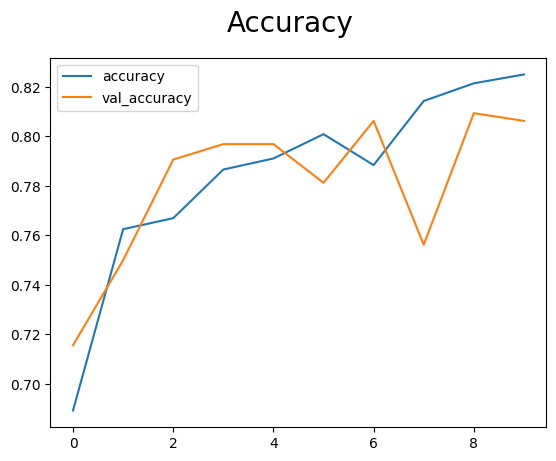

In [47]:
plot_history(hist_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Precision: 0.79, Recall: 0.73, Binary Accuracy: 0.78


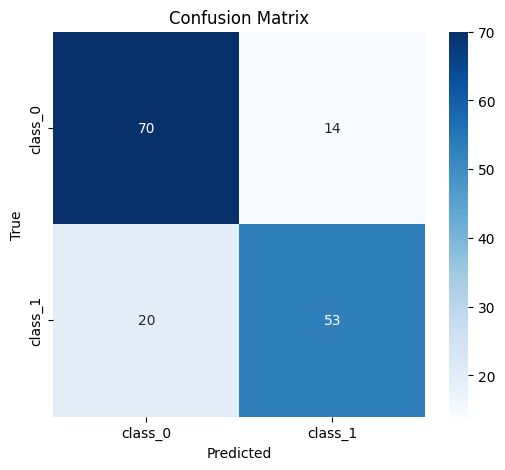

In [48]:
test_model(classifier_rnn, test)